In [1]:
import cv2
import numpy as np 
import glob
from tqdm import tqdm
import PIL.ExifTags
import PIL.Image
from matplotlib import pyplot as plt 

In [2]:
#=====================================
# Function declarations
#=====================================

#Function to create point cloud file
def create_output(vertices, colors, filename):
    colors = colors.reshape(-1,3)
    vertices = np.hstack([vertices.reshape(-1,3),colors])

    ply_header = '''ply
        format ascii 1.0
        element vertex %(vert_num)d
        property float x
        property float y
        property float z
        property uchar red
        property uchar green
        property uchar blue
        end_header
        '''
    with open(filename, 'w') as f:
        f.write(ply_header %dict(vert_num=len(vertices)))
        np.savetxt(f,vertices,'%f %f %f %d %d %d')

#Function that Downsamples image x number (reduce_factor) of times. 
def downsample_image(image, reduce_factor):
    for i in range(0,reduce_factor):
        #Check if image is color or grayscale
        if len(image.shape) > 2:
            row,col = image.shape[:2]
        else:
            row,col = image.shape

        image = cv2.pyrDown(image, dstsize= (col//2, row // 2))
    return image



Computing the disparity  map...


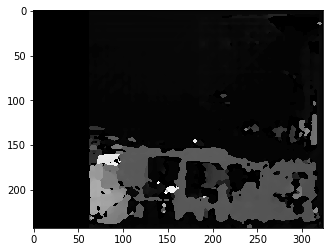


Generating the 3D map...

 Creating the output file... 



In [3]:


#=========================================================
# Stereo 3D reconstruction 
#=========================================================

#Load camera parameters
ret = np.load('./calibration/camera_params/ret.npy')
K = np.load('./calibration/camera_params/K.npy')
dist = np.load('./calibration/camera_params/dist.npy')

#Specify image paths
img_path1 = 'Left.jpg'
img_path2 = 'Right.jpg'

#Load pictures
img_1 = cv2.imread(img_path1)
img_2 = cv2.imread(img_path2)

#Get height and width. Note: It assumes that both pictures are the same size. They HAVE to be same size and height. 
h,w = img_2.shape[:2]

#Get optimal camera matrix for better undistortion 
new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(K,dist,(w,h),1,(w,h))

#Undistort images
img_1_undistorted = cv2.undistort(img_1, K, dist, None, new_camera_matrix)
img_2_undistorted = cv2.undistort(img_2, K, dist, None, new_camera_matrix)

#Downsample each image 3 times (because they're too big)
img_1_downsampled = downsample_image(img_1_undistorted,3)
img_2_downsampled = downsample_image(img_2_undistorted,3)

#cv2.imwrite('undistorted_left.jpg', img_1_downsampled)
#cv2.imwrite('undistorted_right.jpg', img_2_downsampled)


#Set disparity parameters
#Note: disparity range is tuned according to specific parameters obtained through trial and error. 
win_size = 5
min_disp = -1
max_disp = 63 #min_disp * 9
num_disp = max_disp - min_disp # Needs to be divisible by 16

#Create Block matching object. 
stereo = cv2.StereoSGBM_create(minDisparity= min_disp,
    numDisparities = num_disp,
    blockSize = 5,
    uniquenessRatio = 5,
    speckleWindowSize = 5,
    speckleRange = 5,
    disp12MaxDiff = 2,
    P1 = 8*3*win_size**2,#8*3*win_size**2,
    P2 =32*3*win_size**2) #32*3*win_size**2)

#Compute disparity map
print ("\nComputing the disparity  map...")
disparity_map = stereo.compute(img_1_downsampled, img_2_downsampled)

#Show disparity map before generating 3D cloud to verify that point cloud will be usable. 
plt.imshow(disparity_map,'gray')
plt.show()

#Generate  point cloud. 
print ("\nGenerating the 3D map...")

#Get new downsampled width and height 
h,w = img_2_downsampled.shape[:2]

#Load focal length. 
focal_length = np.load('./calibration/camera_params/FocalLength.npy')

#Perspective transformation matrix
#This transformation matrix is from the openCV documentation, didn't seem to work for me. 
Q = np.float32([[1,0,0,-w/2.0],
                [0,-1,0,h/2.0],
                [0,0,0,-focal_length],
                [0,0,1,0]])

#This transformation matrix is derived from Prof. Didier Stricker's power point presentation on computer vision. 
#Link : https://ags.cs.uni-kl.de/fileadmin/inf_ags/3dcv-ws14-15/3DCV_lec01_camera.pdf
Q2 = np.float32([[1,0,0,0],
                [0,-1,0,0],
                [0,0,focal_length*0.05,0], #Focal length multiplication obtained experimentally. 
                [0,0,0,1]])

#Reproject points into 3D
points_3D = cv2.reprojectImageTo3D(disparity_map, Q2)
#Get color points
colors = cv2.cvtColor(img_1_downsampled, cv2.COLOR_BGR2RGB)

#Get rid of points with value 0 (i.e no depth)
mask_map = disparity_map > disparity_map.min()

#Mask colors and points. 
output_points = points_3D[mask_map]
output_colors = colors[mask_map]

#Define name for output file
output_file = 'reconstructed.ply'

#Generate point cloud 
print ("\n Creating the output file... \n")
create_output(output_points, output_colors, output_file)

In [4]:
mask_map

array([[False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True, False],
       ...,
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True, False]])

In [16]:
output_points = np.append(output_points, [1, 0, 0])
output_colors =np.append(output_colors, [255, 0, 0])

In [18]:
output_points = np.append(output_points, [0, 1, 0])
output_colors =np.append(output_colors, [0, 255, 0])
output_points = np.append(output_points, [0, 0, 1])
output_colors =np.append(output_colors, [0, 0, 255])

In [19]:
create_output(output_points, output_colors, output_file)

In [15]:
output_points

array([[  63.   ,    0.   ,    0.   ],
       [  64.   ,    0.   ,    0.   ],
       [  65.   ,    0.   ,    0.   ],
       ...,
       [ 317.   , -242.   ,    0.   ],
       [ 321.   , -242.   ,    0.798],
       [ 322.   , -242.   ,    0.798]], dtype=float32)

In [20]:
dist

array([[-0.07507594, -0.30935397, -0.00151216,  0.00269098,  0.14577352]])